1. Analyze and Preprocess data - Check if the dataset has missing values or has any other problem.
2. Feature Engineering
3. Sampling Your Data
4. Build Model
    4. a. Try DecisionTree, RandomForest
    4. b. Try other tree-based model like: XGBoost, CatBoost
5. Perform model on training set and test set using gridsearch CV
6. Measure performance of the model.
7. Which metric is your main metric for this problem and why? What is your main model as well as their params and why?


How can I measure your point:
1. Your function is callable and runs correctly
2. The performance of your model (in full pipeline) is acceptable.
3. The data preprocessing is correct or make sense
4. The Feature engineering is correct or make sense
5. Any other additional process will be considered a small plus point.

Churn rate is a marketing metric that describes the number of customers who leave a business over a specific time period. Every user is assigned a prediction value that estimates their state of churn at any given time. This value is based on:

User demographic information
Browsing behavior
Historical purchase data among other information
It factors in our unique and proprietary predictions of how long a user will remain a customer. This score is updated every day for all users who have a minimum of one conversion. The values assigned are between 1 and 5.

## Load Dataset

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [37]:
import pandas as pd
PATH = r"D:\Kì 6\Nhập môn học máy\Thực hành\Lab04\HomeWork-churn_rate_prediction.csv"

df = pd.read_csv(PATH)
df.head()

customer_id              Name  age gender  \
0      fffe4300490044003600300030003800   Pattie Morrisey   18      F   
1  fffe43004900440032003100300035003700       Traci Peery   32      F   
2      fffe4300490044003100390032003600   Merideth Mcmeen   44      F   
3  fffe43004900440036003000330031003600  Eufemia Cardwell   37      M   
4  fffe43004900440031003900350030003600      Meghan Kosak   31      F   

  security_no region_category  membership_category joining_date  \
0     XW0DQ7H         Village  Platinum Membership   2017-08-17   
1     5K0N3X1            City   Premium Membership   2017-08-28   
2     1F2TCL3            Town        No Membership   2016-11-11   
3     VJGJ33N            City        No Membership   2016-10-29   
4     SVZXCWB            City        No Membership   2017-09-12   

  joined_through_referral referral_id  ... avg_time_spent  \
0                      No    xxxxxxxx  ...         300.63   
1                       ?    CID21329  ...         306.34   
2                     Yes    CID12313  ...         516.16   
3                     Yes     CID3793  ...          53.27   
4                      No    xxxxxxxx  ...         113.13   

  avg_transaction_value avg_frequency_login_days points_in_wallet  \
0              53005.25                     17.0           781.75   
1              12838.38                     10.0              NaN   
2              21027.00                     22.0           500.69   
3              25239.56                      6.0           567.66   
4              24483.66                     16.0           663.06   

   used_special_discount  offer_application_preference  past_complaint  \
0                    Yes                           Yes              No   
1                    Yes                            No             Yes   
2                     No                           Yes             Yes   
3                     No                           Yes             Yes   
4                     No                           Yes             Yes   

      complaint_status                  feedback churn_risk_score  
0       Not Applicable  Products always in Stock                2  
1               Solved     Quality Customer Care                1  
2  Solved in Follow-up              Poor Website                5  
3             Unsolved              Poor Website                5  
4               Solved              Poor Website                5  

[5 rows x 25 columns]

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36992 non-null  object 
 1   Name                          36992 non-null  object 
 2   age                           36992 non-null  int64  
 3   gender                        36992 non-null  object 
 4   security_no                   36992 non-null  object 
 5   region_category               31564 non-null  object 
 6   membership_category           36992 non-null  object 
 7   joining_date                  36992 non-null  object 
 8   joined_through_referral       36992 non-null  object 
 9   referral_id                   36992 non-null  object 
 10  preferred_offer_types         36704 non-null  object 
 11  medium_of_operation           36992 non-null  object 
 12  internet_option               36992 non-null  object 
 13  l

## Data Analysis

In [39]:
from pandas_profiling import ProfileReport
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Preprocessing

In [40]:
df.isnull().sum()

customer_id                        0
Name                               0
age                                0
gender                             0
security_no                        0
region_category                 5428
membership_category                0
joining_date                       0
joined_through_referral            0
referral_id                        0
preferred_offer_types            288
medium_of_operation                0
internet_option                    0
last_visit_time                    0
days_since_last_login              0
avg_time_spent                     0
avg_transaction_value              0
avg_frequency_login_days           0
points_in_wallet                3443
used_special_discount              0
offer_application_preference       0
past_complaint                     0
complaint_status                   0
feedback                           0
churn_risk_score                   0
dtype: int64

In [41]:
def preprocessing_data(df):
    """
    Preprocess your data (eg. Drop null datapoints or fill missing data)
    :param df: pandas DataFrame
    :return: pandas DataFrame
    """
    # Lấy các giá trị unknown của 'gender' và chuyển thành null
    df['gender'].mask((df['gender'] != 'F') & (df['gender'] != 'M'), np.nan, inplace=True)

    # Chuyển các giá trị nằm ngoài khoảng [1,5] của churn thành null
    df['churn_risk_score'].mask((df['churn_risk_score'] < 1) | (df['churn_risk_score'] > 5), np.nan, inplace=True)    

    # Drop các giá trị null
    df.dropna(axis=0, subset=['gender', 'preferred_offer_types', 'churn_risk_score'], inplace=True)

    # Thay thế các missing values ở cột 'region_category' bằng giá trị phổ biến nhất
    most_common_value = df['region_category'].mode().iloc[0]
    df['region_category'].fillna(most_common_value, inplace=True)

    # Thay thế các missing values và negative values ở cột 'points_in_wallet' bằng giá trị trung bình
    df['points_in_wallet'].mask(df['points_in_wallet'] < 0, np.nan, inplace=True) 
    mean_value = df['points_in_wallet'].mean()
    df['points_in_wallet'].fillna(mean_value, inplace=True)

    # Thay thế các giá trị Error ở cột 'avg_frequency_login_days' bằng giá trị trung bình
    df['avg_frequency_login_days'].replace('Error', np.nan, inplace=True)
    df['avg_frequency_login_days'] = df['avg_frequency_login_days'].astype(float)
    df['avg_frequency_login_days'].mask(df['avg_frequency_login_days'] < 0, np.nan, inplace=True) 
    mean_value = df['avg_frequency_login_days'].mean()
    df['avg_frequency_login_days'].fillna(mean_value, inplace=True)

    # Thay thế các missing values ở cột 'medium_of_operation' bằng giá trị phổ biến nhất
    most_common_value = df['medium_of_operation'].mode().iloc[0]
    df['medium_of_operation'].replace('?', most_common_value, inplace=True)


    # Thay thế các giá trị âm ở cột 'avg_time_spent' bằng giá trị trung bình
    df['avg_time_spent'].mask(df['avg_time_spent'] < 0, np.nan, inplace=True) 
    df['avg_time_spent'].fillna(df['avg_time_spent'].mean(), inplace=True)


    # Thay thế các missing values ở cột 'joined_through_referral' bằng giá trị phổ biến nhất
    most_common_value = df['joined_through_referral'].mode().iloc[0]
    df['joined_through_referral'].replace('?', most_common_value, inplace=True)

    # Thay thế các missing values ở cột 'avg_frequency_login_days' bằng giá trị trung bình
    mean_value = df['avg_frequency_login_days'].mean()
    df['avg_frequency_login_days'].fillna(mean_value, inplace=True)
    
    return df

In [42]:
df = preprocessing_data(df.copy())

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35498 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   35498 non-null  object 
 1   Name                          35498 non-null  object 
 2   age                           35498 non-null  int64  
 3   gender                        35498 non-null  object 
 4   security_no                   35498 non-null  object 
 5   region_category               35498 non-null  object 
 6   membership_category           35498 non-null  object 
 7   joining_date                  35498 non-null  object 
 8   joined_through_referral       35498 non-null  object 
 9   referral_id                   35498 non-null  object 
 10  preferred_offer_types         35498 non-null  object 
 11  medium_of_operation           35498 non-null  object 
 12  internet_option               35498 non-null  object 
 13  l

In [44]:
df['feedback'].info()

<class 'pandas.core.series.Series'>
Int64Index: 35498 entries, 0 to 36991
Series name: feedback
Non-Null Count  Dtype 
--------------  ----- 
35498 non-null  object
dtypes: object(1)
memory usage: 554.7+ KB


## Feature Engineering

In [45]:
# Heatmap
import seaborn as sns

def apply_feature_engineering(df):
    """
    Apply all feature engineering to transform your data into number
    :param df: pandas DataFrame
    :return: pandas DataFrame
    """
    df = df.drop(columns=['customer_id', 'Name', 'security_no', 'joining_date', 'referral_id', 'last_visit_time', 'days_since_last_login'])
    df_categorical = df[['gender', 'region_category', 'membership_category', 'joined_through_referral', 'preferred_offer_types', 'medium_of_operation', 'internet_option',\
                         'used_special_discount', 'offer_application_preference', 'past_complaint', 'complaint_status', 'feedback']]
    for i in range(df_categorical.shape[1]):
        df[df_categorical.columns[i]] = df[df_categorical.columns[i]].astype('category').cat.codes
    
    return df

df = apply_feature_engineering(df.copy())
df

age  gender  region_category  membership_category  \
0       18       0                2                    3   
1       32       0                0                    4   
2       44       0                1                    2   
3       37       1                0                    2   
4       31       0                0                    2   
...    ...     ...              ...                  ...   
36987   46       0                1                    0   
36988   29       0                1                    0   
36989   23       0                1                    0   
36990   53       1                2                    3   
36991   35       1                1                    5   

       joined_through_referral  preferred_offer_types  medium_of_operation  \
0                            0                      1                    1   
1                            0                      1                    1   
2                            1                      1                    1   
3                            1                      1                    1   
4                            0                      0                    2   
...                        ...                    ...                  ...   
36987                        0                      0                    1   
36988                        0                      2                    2   
36989                        1                      1                    1   
36990                        0                      1                    2   
36991                        0                      1                    1   

       internet_option  avg_time_spent  avg_transaction_value  \
0                    2      300.630000               53005.25   
1                    1      306.340000               12838.38   
2                    2      516.160000               21027.00   
3                    1       53.270000               25239.56   
4                    1      113.130000               24483.66   
...                ...             ...                    ...   
36987                2      292.441384               27277.68   
36988                2      292.441384               11069.71   
36989                2      154.940000               38127.56   
36990                1      482.610000                2378.86   
36991                1       79.180000                2189.68   

       avg_frequency_login_days  points_in_wallet  used_special_discount  \
0                     17.000000        781.750000                      1   
1                     10.000000        690.414754                      1   
2                     22.000000        500.690000                      0   
3                      6.000000        567.660000                      0   
4                     16.000000        663.060000                      0   
...                         ...               ...                    ...   
36987                  6.000000        639.510000                      0   
36988                 28.000000        527.990000                      1   
36989                 16.518691        680.470000                      0   
36990                 20.000000        197.264414                      1   
36991                 16.518691        719.970000                      1   

       offer_application_preference  past_complaint  complaint_status  \
0                                 1               0                 1   
1                                 0               1                 2   
2                                 1               1                 3   
3                                 1               1                 4   
4                                 1               1                 2   
...                             ...             ...               ...   
36987                             1               1                 0   
36988                             0               0                 1  

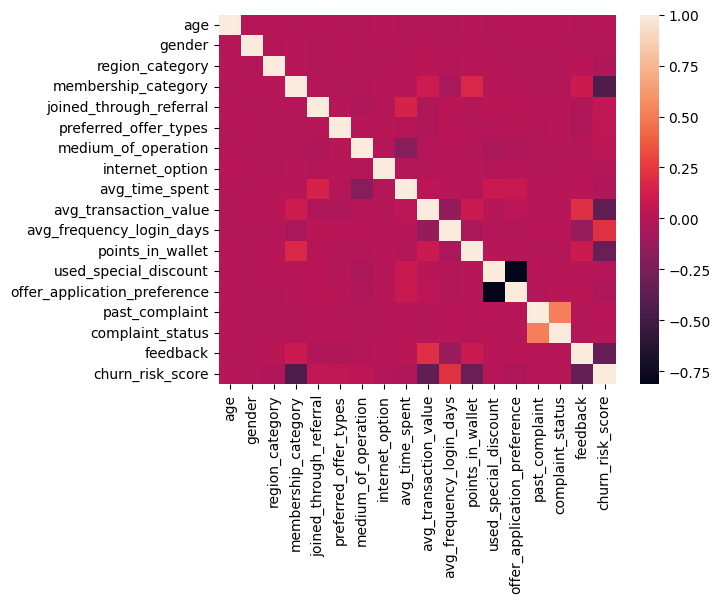

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.heatmap(df.corr())
plt.show()

In [48]:
def prepare_X_y(df):
    """
    Feature engineering and create X and y
    :param df: pandas dataframe
    :return: (X, y) output feature matrix (dataframe), target (series)
    """
    # Todo: Split data into X and y (using sklearn train_test_split). Return two dataframes
    feature = df.columns.tolist()
    feature.remove('churn_risk_score')
    X = df[feature].values
    y = df.churn_risk_score.values
    return X, y

X, y = prepare_X_y(df)

# Apply machine learning model

## Train-test split

In [49]:
from sklearn.model_selection import train_test_split
RANDOM_STATE = 1
TRAIN_SIZE = 0.7

trainX, testX ,trainY, testY = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

In [50]:
len(trainX)

24848

## Build SK-learn model

In [63]:
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_curve

In [64]:
# Decision Tree
def build_model(X, y):
    """
    Design your model and train it (including your best params)
    :param X: feature matrix
    :param y: target
    :return: a model
    """
    #scaler = StandardScaler()
    dt = DecisionTreeClassifier()
    pipe = Pipeline(steps=[("tree", dt)])
    param_grid = {
        'tree__criterion': ["gini", "entropy", "log_loss"]
        }
    
    search = GridSearchCV(pipe, param_grid, scoring="f1_micro", n_jobs=2)
    search.fit(X, y.ravel())
    print("Best score : ", search.best_score_)
    print("Best parameter : ", search.best_params_)

    return search

model = build_model(trainX, trainY)
# Compare on training dataset
pred = model.predict(testX)
print()
print(classification_report(testY, pred))

Best score :  0.7627975297953954
Best parameter :  {'tree__criterion': 'entropy'}

              precision    recall  f1-score   support

         1.0       0.72      0.77      0.74       773
         2.0       0.77      0.72      0.75       821
         3.0       0.92      0.91      0.91      3183
         4.0       0.64      0.67      0.65      2906
         5.0       0.75      0.73      0.74      2967

    accuracy                           0.77     10650
   macro avg       0.76      0.76      0.76     10650
weighted avg       0.77      0.77      0.77     10650



In [65]:
# Random Forest
def build_model(X, y):
    """
    Design your model and train it (including your best params)
    :param X: feature matrix
    :param y: target
    :return: a model
    """
    #scaler = StandardScaler()
    rf = RandomForestClassifier()
    pipe = Pipeline(steps=[("tree", rf)])
    param_grid = {
        'tree__criterion': ["gini", "entropy", "log_loss"]
        }
    
    search = GridSearchCV(pipe, param_grid, scoring="f1_micro", n_jobs=2)
    search.fit(X, y.ravel())
    print("Best score : ", search.best_score_)
    print("Best parameter : ", search.best_params_)

    return search

model = build_model(trainX, trainY)
# Compare on training dataset
pred = model.predict(testX)
print()
print(classification_report(testY, pred))

Best score :  0.7711285219872263
Best parameter :  {'tree__criterion': 'log_loss'}

              precision    recall  f1-score   support

         1.0       0.71      0.84      0.77       773
         2.0       0.82      0.67      0.74       821
         3.0       0.91      0.90      0.91      3183
         4.0       0.68      0.61      0.64      2906
         5.0       0.73      0.82      0.77      2967

    accuracy                           0.78     10650
   macro avg       0.77      0.77      0.77     10650
weighted avg       0.78      0.78      0.77     10650



In [66]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
trainX_os, trainY_os = smote.fit_resample(trainX, trainY)

In [67]:

def build_model(X, y):
    """
    Design your model and train it (including your best params)
    :param X: feature matrix
    :param y: target
    :return: a model
    """
    model = DecisionTreeClassifier()
    pipe = Pipeline(steps=[("tree", model)])
    param_grid = {
        'tree__criterion': ["gini", "entropy", "log_loss"]
        }
    
    search = GridSearchCV(pipe, param_grid, scoring="f1_micro", n_jobs=2)
    search.fit(X, y)
    print("Best score : ", search.best_score_)
    print("Best parameter : ", search.best_params_)

    return search

model = build_model(trainX, trainY)
# Compare on training dataset
pred = model.predict(testX)
print()
print(classification_report(testY, pred))

Best score :  0.7632404529815238
Best parameter :  {'tree__criterion': 'entropy'}

              precision    recall  f1-score   support

         1.0       0.71      0.76      0.74       773
         2.0       0.76      0.72      0.74       821
         3.0       0.92      0.91      0.91      3183
         4.0       0.64      0.67      0.65      2906
         5.0       0.75      0.73      0.74      2967

    accuracy                           0.77     10650
   macro avg       0.76      0.76      0.76     10650
weighted avg       0.77      0.77      0.77     10650



Main metric là f1_micro. \
Vì f1_micro là một trong các metric được sử dụng để đánh giá hiệu suất của mô hình dự đoán đa lớp.\
f1_micro phù hợp khi mô hình cần phải phân loại một tập dữ liệu mà các lớp có số lượng mẫu không đồng đều.\